# Análisis de Varianza (ANOVA) para Comparación de Grupos

## **Ejercicio:** ANOVA para análisis de segmentación de clientes por canal de adquisición

#### Preparación de datos y configuración

In [27]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Generar datos de segmentación de clientes
np.random.seed(42)
n_clientes = 300

# Canales de adquisición
canales = ['Redes Sociales', 'Búsqueda Orgánica', 'Email Marketing', 'Publicidad Paga', 'Referidos']
pesos_canales = [0.3, 0.25, 0.2, 0.15, 0.1]  # Distribución de clientes

# Asignar clientes a canales
canal_asignado = np.random.choice(canales, n_clientes, p=pesos_canales)

# Generar valor de vida del cliente (CLV) por canal con diferencias
clv_por_canal = {
    'Redes Sociales': np.random.normal(450, 120, 1),    # CLV más bajo
    'Búsqueda Orgánica': np.random.normal(520, 110, 1),
    'Email Marketing': np.random.normal(680, 140, 1),   # CLV alto
    'Publicidad Paga': np.random.normal(590, 130, 1),
    'Referidos': np.random.normal(750, 150, 1)          # CLV más alto
}

# Generar CLV para cada cliente
clv_data = []
for cliente, canal in enumerate(canal_asignado):
    base_clv = clv_por_canal[canal][0]
    # Añadir variabilidad individual
    clv_individual = np.random.normal(base_clv, base_clv * 0.3)
    clv_data.append(max(0, clv_individual))  # CLV no puede ser negativo

# Crear DataFrame
df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'canal_adquisicion': canal_asignado,
    'clv': clv_data
})

print("ANÁLISIS ANOVA - SEGMENTACIÓN POR CANAL")
print("=" * 45)
print(f"Total clientes analizados: {len(df)}")
print(f"Canales evaluados: {len(canales)}")
print(f"Rango CLV: ${df['clv'].min():.0f} - ${df['clv'].max():.0f}")

ANÁLISIS ANOVA - SEGMENTACIÓN POR CANAL
Total clientes analizados: 300
Canales evaluados: 5
Rango CLV: $19 - $1613


#### Verificación de sunciones del ANOVA

In [28]:
# Preparar datos por grupo
grupos_clv = {}
for canal in canales:
    grupos_clv[canal] = df[df['canal_adquisicion'] == canal]['clv'].values

print("\nVERIFICACIÓN DE ASUNCIONES")
print("-" * 30)

# Verificar tamaños de grupos
for canal, datos in grupos_clv.items():
    print(f"{canal}: n={len(datos)}, media=${datos.mean():.0f}")

# Prueba de normalidad (Shapiro-Wilk)
print("NORMALIDAD POR GRUPO:")
for canal, datos in grupos_clv.items():
    if len(datos) >= 3:  # Shapiro requiere al menos 3 observaciones
        stat, p = stats.shapiro(datos)
        normal = "Sí" if p > 0.05 else "No"
        print(f"{canal}: {normal} (p={p:.3f})")
    else:
        print(f"{canal}: n={len(datos)} (shapiro no aplica)")


VERIFICACIÓN DE ASUNCIONES
------------------------------
Redes Sociales: n=95, media=$443
Búsqueda Orgánica: n=70, media=$446
Email Marketing: n=59, media=$963
Publicidad Paga: n=47, media=$685
Referidos: n=29, media=$459
NORMALIDAD POR GRUPO:
Redes Sociales: Sí (p=0.783)
Búsqueda Orgánica: Sí (p=0.504)
Email Marketing: Sí (p=0.111)
Publicidad Paga: Sí (p=0.166)
Referidos: Sí (p=0.514)


#### Prueba de homocedasticidad (Levene)

In [29]:
stat, p = stats.levene(*grupos_clv.values())
homocedastico = "Sí" if p > 0.05 else "No"
print(f"\nHomocedasticidad (Levene): {homocedastico} (p={p:.3f})")


Homocedasticidad (Levene): No (p=0.000)


#### Si no hay honocedasticidad, considerar prueba robusta

In [30]:
if p <= 0.05:
    print("ADVERTENCIA: Varianzas no son iguales - considerar transformación de datos")

# Ejecutar ANOVA
f_stat, p_value = stats.f_oneway(*grupos_clv.values())

print("\nRESULTADOS ANOVA")
print("-" * 20)
print(f"Estadístico F: {f_stat:.3f}")
print(f"Valor p: {p_value:.4f}")
print(f"Grados de libertad: {len(canales)-1} entre grupos, {len(df)-len(canales)} dentro grupos")
print(f"Significativo (α=0.05): {'SÍ' if p_value < 0.05 else 'NO'}")

if p_value < 0.05:
    print("CONCLUSIÓN: Existen diferencias significativas en CLV entre canales")
else:
    print("CONCLUSIÓN: No hay evidencia de diferencias significativas en CLV")

# Calcular eta cuadrado (tamaño del efecto)
ssb = sum(len(grupo) * (np.mean(grupo) - df['clv'].mean())**2 for grupo in grupos_clv.values())
sst = sum((x - df['clv'].mean())**2 for x in df['clv'])
eta_cuadrado = ssb / sst if sst != 0 else np.nan

print(f"Tamaño del efecto (η²): {eta_cuadrado:.3f}")
interpretacion = "Grande" if eta_cuadrado > 0.14 else ("Mediano" if eta_cuadrado > 0.06 else "Pequeño")
print(f"Interpretación: {interpretacion}")

# Ejecutar ANOVA
f_stat, p_value = stats.f_oneway(*grupos_clv.values())

print(f"\nRESULTADOS ANOVA")
print("-" * 20)
print(f"Estadístico F: {f_stat:.3f}")
print(f"Valor p: {p_value:.4f}")
print(f"Grados de libertad: {len(canales)-1} entre grupos, {len(df)-len(canales)} dentro grupos")
print(f"Significativo (α=0.05): {'SÍ' if p_value < 0.05 else 'NO'}")

if p_value < 0.05:
    print("CONCLUSIÓN: Existen diferencias significativas en CLV entre canales")
else:
    print("CONCLUSIÓN: No hay evidencia de diferencias significativas en CLV")

# Calcular eta cuadrado (tamaño del efecto)
ssb = sum(len(grupo) * (np.mean(grupo) - df['clv'].mean())**2 for grupo in grupos_clv.values())
sst = sum((x - df['clv'].mean())**2 for x in df['clv'])
eta_cuadrado = ssb / sst

print(f"Tamaño del efecto (η²): {eta_cuadrado:.3f}")
print(f"Interpretación: {'Grande' if eta_cuadrado > 0.14 else 'Mediano' if eta_cuadrado > 0.06 else 'Pequeño'}")


ADVERTENCIA: Varianzas no son iguales - considerar transformación de datos

RESULTADOS ANOVA
--------------------
Estadístico F: 91.349
Valor p: 0.0000
Grados de libertad: 4 entre grupos, 295 dentro grupos
Significativo (α=0.05): SÍ
CONCLUSIÓN: Existen diferencias significativas en CLV entre canales
Tamaño del efecto (η²): 0.553
Interpretación: Grande

RESULTADOS ANOVA
--------------------
Estadístico F: 91.349
Valor p: 0.0000
Grados de libertad: 4 entre grupos, 295 dentro grupos
Significativo (α=0.05): SÍ
CONCLUSIÓN: Existen diferencias significativas en CLV entre canales
Tamaño del efecto (η²): 0.553
Interpretación: Grande


#### Pruebas post-hoc con Tukey HSD

In [31]:
# Preparar datos para Tukey
df_tukey = df.copy()

# Ejecutar prueba de Tukey
tukey = pairwise_tukeyhsd(df_tukey['clv'], df_tukey['canal_adquisicion'], alpha=0.05)

print(f"\nPRUEBAS POST-HOC - TUKEY HSD")
print("=" * 35)
print(tukey)

# Obtener nombres únicos de grupos y generar pares de comparaciones
grupos_unicos = sorted(df_tukey['canal_adquisicion'].unique())
comparaciones_pares = []
for i in range(len(grupos_unicos)):
    for j in range(i+1, len(grupos_unicos)):
        comparaciones_pares.append((grupos_unicos[i], grupos_unicos[j]))

# Analizar resultados significativos
resultados_tukey = pd.DataFrame({
    'group1': [pair[0] for pair in comparaciones_pares],
    'group2': [pair[1] for pair in comparaciones_pares],
    'meandiff': tukey.meandiffs,
    'p_adj': tukey.pvalues,
    'reject': tukey.reject
})

print("\nCOMPARACIONES SIGNIFICATIVAS:")
significativas = resultados_tukey[resultados_tukey['reject']]
if len(significativas) > 0:
    for _, row in significativas.iterrows():
        print(f"{row['group1']} vs {row['group2']}: diferencia=${row['meandiff']:.0f} (p={row['p_adj']:.3f})")
else:
    print("No hay diferencias significativas entre pares específicos")


PRUEBAS POST-HOC - TUKEY HSD
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1           group2      meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------------
Búsqueda Orgánica Email Marketing  517.2389    0.0  427.0441  607.4337   True
Búsqueda Orgánica Publicidad Paga  239.0542    0.0   142.814  335.2944   True
Búsqueda Orgánica  Redes Sociales   -2.8208    1.0  -83.2091   77.5675  False
Búsqueda Orgánica       Referidos   13.3216 0.9976  -99.3803  126.0235  False
  Email Marketing Publicidad Paga -278.1847    0.0 -377.9638 -178.4056   True
  Email Marketing  Redes Sociales -520.0597    0.0 -604.6526 -435.4667   True
  Email Marketing       Referidos -503.9173    0.0 -619.6558 -388.1788   True
  Publicidad Paga  Redes Sociales  -241.875    0.0 -332.8863 -150.8638   True
  Publicidad Paga       Referidos -225.7326    0.0 -346.2419 -105.2233   True
   Redes Sociales       Referidos 

#### Visualización completa de resultados

C:\Users\marely\AppData\Local\Temp\ipykernel_21916\3940661036.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([grupos_clv[canal] for canal in canales], labels=canales, patch_artist=True)



Análisis completo guardado como 'analisis_anova_segmentacion_canales.png'


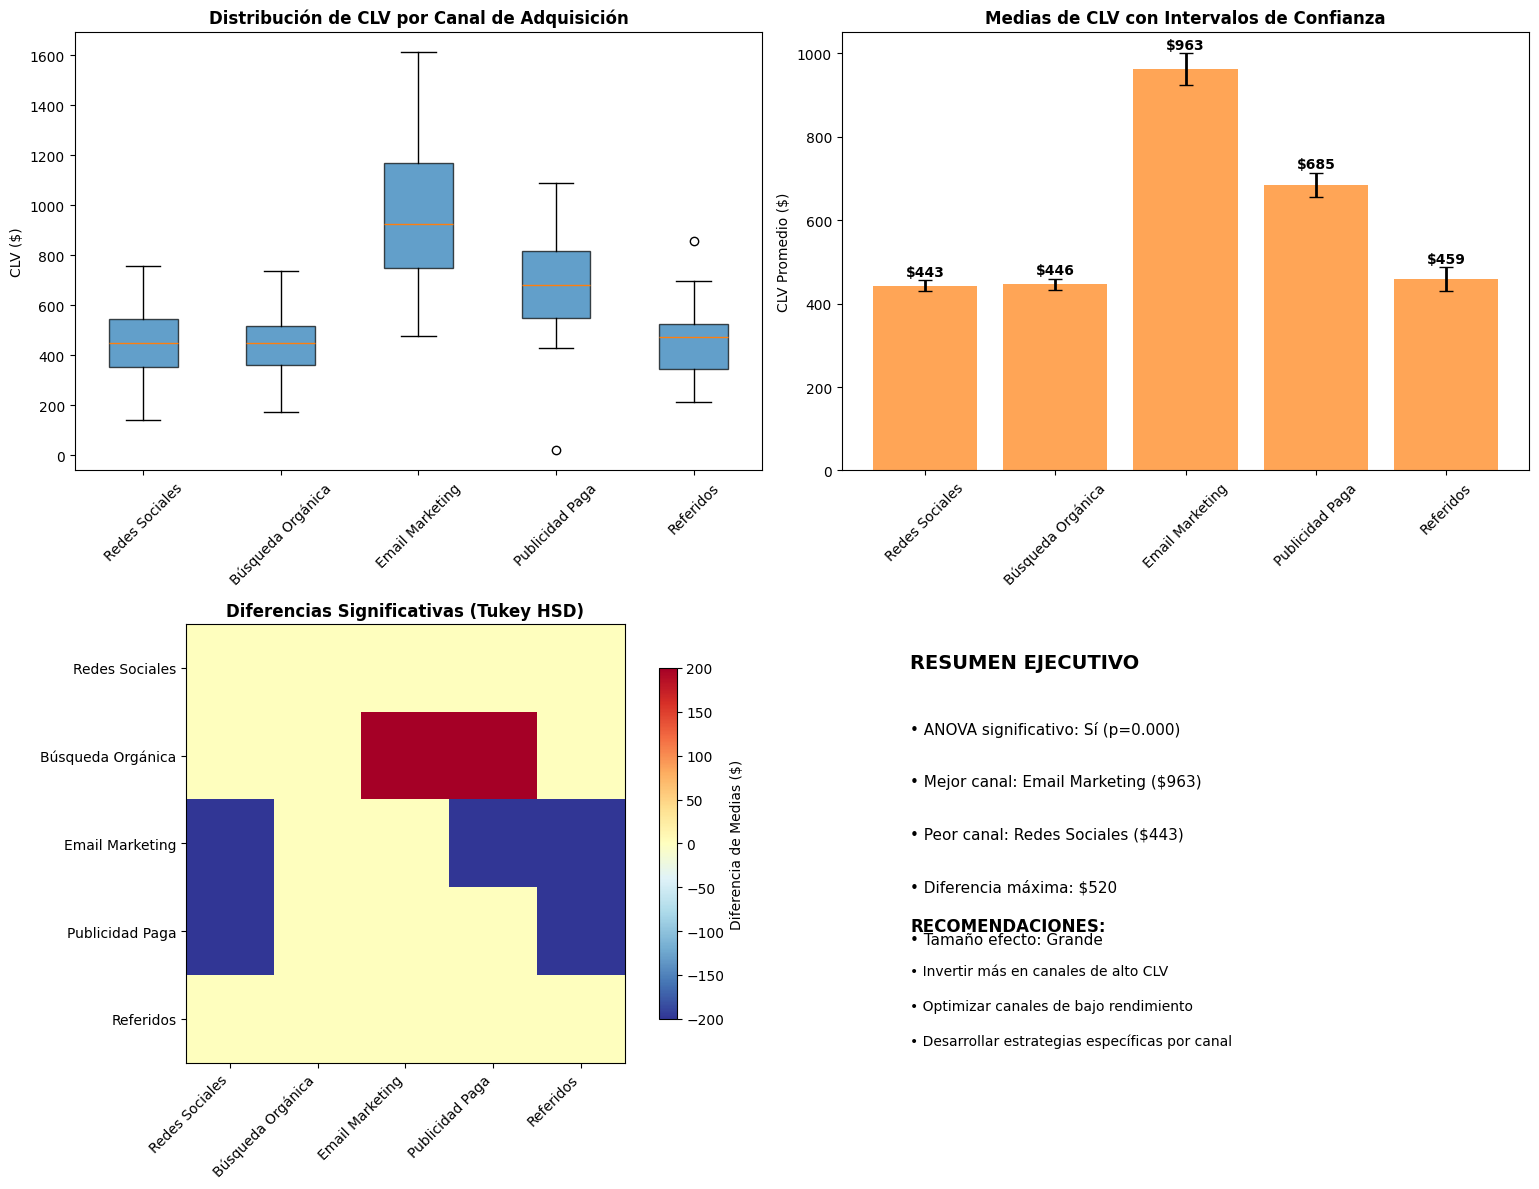

In [33]:
# Crear visualización comprehensiva
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plot de CLV por canal
bp = ax1.boxplot([grupos_clv[canal] for canal in canales], labels=canales, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#1f77b4')
    patch.set_alpha(0.7)
ax1.set_title('Distribución de CLV por Canal de Adquisición', fontweight='bold')
ax1.set_ylabel('CLV ($)')
ax1.tick_params(axis='x', rotation=45)

# 2. Gráfico de barras de medias con intervalos de confianza
medias = [np.mean(grupos_clv[canal]) for canal in canales]
errores = [stats.sem(grupos_clv[canal]) for canal in canales]  # Error estándar

bars = ax2.bar(range(len(canales)), medias, yerr=errores, capsize=5, color='#ff7f0e', alpha=0.7, error_kw={'ecolor': 'black', 'linewidth': 2})
ax2.set_title('Medias de CLV con Intervalos de Confianza', fontweight='bold')
ax2.set_ylabel('CLV Promedio ($)')
ax2.set_xticks(range(len(canales)))
ax2.set_xticklabels(canales, rotation=45)

# Añadir valores encima de barras
for i, (media, error) in enumerate(zip(medias, errores)):
    ax2.text(i, media + error + 10, f'${media:.0f}', ha='center', fontweight='bold')

# 3. Gráfico de diferencias significativas (Tukey)
# Crear matriz de diferencias
n_canales = len(canales)
diff_matrix = np.zeros((n_canales, n_canales))

for _, row in resultados_tukey.iterrows():
    i = canales.index(row['group1'])
    j = canales.index(row['group2'])
    diff_matrix[i, j] = row['meandiff'] if row['reject'] else 0

im = ax3.imshow(diff_matrix, cmap='RdYlBu_r', vmin=-200, vmax=200)
ax3.set_xticks(range(n_canales))
ax3.set_yticks(range(n_canales))
ax3.set_xticklabels(canales, rotation=45, ha='right')
ax3.set_yticklabels(canales)
ax3.set_title('Diferencias Significativas (Tukey HSD)', fontweight='bold')

# Barra de color
cbar = fig.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Diferencia de Medias ($)')

# 4. Resumen ejecutivo
ax4.axis('off')
ax4.text(0.1, 0.9, 'RESUMEN EJECUTIVO', fontsize=14, fontweight='bold')

resumen = [
    f"• ANOVA significativo: {'Sí' if p_value < 0.05 else 'No'} (p={p_value:.3f})",
    f"• Mejor canal: {canales[np.argmax(medias)]} (${medias[np.argmax(medias)]:.0f})",
    f"• Peor canal: {canales[np.argmin(medias)]} (${medias[np.argmin(medias)]:.0f})",
    f"• Diferencia máxima: ${max(medias) - min(medias):.0f}",
    f"• Tamaño efecto: {'Grande' if eta_cuadrado > 0.14 else 'Mediano' if eta_cuadrado > 0.06 else 'Pequeño'}"
]

y_pos = 0.75
for item in resumen:
    ax4.text(0.1, y_pos, item, fontsize=11)
    y_pos -= 0.12

# Recomendaciones
ax4.text(0.1, 0.3, 'RECOMENDACIONES:', fontsize=12, fontweight='bold')
recomendaciones = [
    "• Invertir más en canales de alto CLV",
    "• Optimizar canales de bajo rendimiento",
    "• Desarrollar estrategias específicas por canal"
]

y_pos = 0.2
for rec in recomendaciones:
    ax4.text(0.1, y_pos, rec, fontsize=10)
    y_pos -= 0.08

plt.tight_layout()
plt.savefig('analisis_anova_segmentacion_canales.png', dpi=300, bbox_inches='tight')
print("\nAnálisis completo guardado como 'analisis_anova_segmentacion_canales.png'")